In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
import numpy as np


# from IPython.display import display
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.expand_frame_repr', True)
# import warnings
# warnings.filterwarnings('ignore')



In [46]:
# Parameters
study = "GRNvoxels"
experiments = "noveltysearch,novelty"
runs = "1,2"
generations = 10
final_gen = 9
out_path = "/home/ripper8/projects/working_data"



In [48]:
analysis_path = f'{out_path}/{study}/analysis'

def parse_csv_list(s, cast=int):
    return [cast(x.strip()) for x in str(s).split(",") if x.strip()]

runs = parse_csv_list(runs, int)      # "1,2" -> [1, 2], "3" -> [3]
experiments = parse_csv_list(experiments, str)


,experiment,generation,uniqueness_mean_median,uniqueness_mean_q25,uniqueness_mean_q75,fitness_mean_median,fitness_mean_q25,fitness_mean_q75,num_voxels_mean_median,num_voxels_mean_q25,num_voxels_mean_q75,fitness_max_median,fitness_max_q25,fitness_max_q75
0,novelty,0,4.872222,4.252778,5.491667,4.872222,4.252778,5.491667,0.0,0.0,0.0,7.583333,6.791667,8.375000
1,novelty,1,7.750000,6.902778,8.597222,7.750000,6.902778,8.597222,0.0,0.0,0.0,11.777778,10.333333,13.222222
2,novelty,2,9.911111,8.827778,10.994444,9.911111,8.827778,10.994444,0.0,0.0,0.0,13.916667,12.263889,15.569444
3,novelty,3,12.511111,12.244444,12.777778,12.511111,12.244444,12.777778,0.0,0.0,0.0,19.250000,18.319444,20.180556
4,novelty,4,14.377778,13.550000,15.205556,14.377778,13.550000,15.205556,0.0,0.0,0.0,20.000000,19.250000,20.750000
5,novelty,5,16.400000,15.950000,16.850000,16.400000,15.950000,16.850000,0.0,0.0,0.0,20.000000,19.444444,20.555556
6,novelty,6,17.094444,16.658333,17.530556,17.094444,16.658333,17.530556,0.0,0.0,0.0,19.527778,18.513889,20.541667
7,novelty,7,18.955556,17.427778,20.483333,18.955556,17.427778,20.483333,0.0,0.0,0.0,21.472222,19.763889,23.180556
8,novelty,8,20.694444,18.391667,22.997222,20.694444,18.391667,22.997222,0.0,0.0,0.0,25.083333,21.625000,28.541667
9,novelty,9,20.816667,18.163889,23.469444,20.816667,18.163889,23.469444,0.0,0.0,0.0,24.388889,21.388889,27.388889


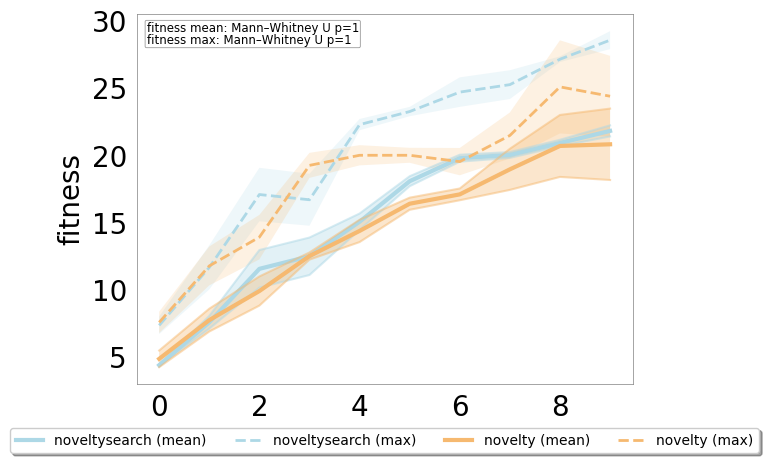

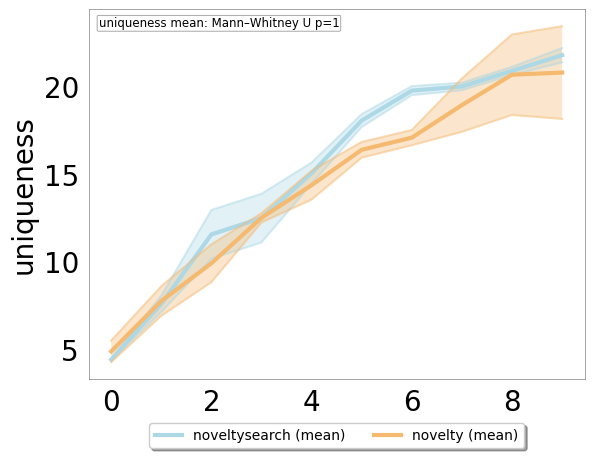

In [51]:
### Metrics progression ###

gens_robots_outer = pd.read_csv(f'{analysis_path}/gens_robots_outer.csv')
gens_robots_inner = pd.read_csv(f'{analysis_path}/gens_robots_inner.csv')

display(gens_robots_outer)

metrics = ['fitness', 'uniqueness']
metrics_labels = ['fitness', 'uniqueness']

clrs = ['#ADD8E6', '#F6B970']

def cols(prefix):
    """Return (median, q1, q3) column names for a given prefix."""
    return f'{prefix}_median', f'{prefix}_q25', f'{prefix}_q75'

def choose_test(a, b):
    """Return (label, p, effect_label, effect_value)."""
    a = pd.Series(a).dropna()
    b = pd.Series(b).dropna()
    if len(a) < 2 or len(b) < 2:
        return ("n<2", np.nan, "", np.nan)

    # Normality (only meaningful for n>=3; else force nonparametric)
    if len(a) >= 3 and len(b) >= 3:
        p_norm_a = shapiro(a).pvalue
        p_norm_b = shapiro(b).pvalue
        normal = (p_norm_a > 0.05) and (p_norm_b > 0.05)
    else:
        normal = False

    if normal:
        # Homoskedasticity
        p_lev = levene(a, b).pvalue
        equal_var = p_lev > 0.05
        # Student (equal_var=True) or Welch (equal_var=False)
        t_res = ttest_ind(a, b, equal_var=equal_var)
        p = t_res.pvalue
        # Hedges' g
        n1, n2 = len(a), len(b)
        m1, m2 = a.mean(), b.mean()
        s1, s2 = a.std(ddof=1), b.std(ddof=1)
        sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2)) if (n1+n2-2) > 0 else np.nan
        d = (m1 - m2) / sp if sp and sp > 0 else np.nan
        J = 1 - (3 / (4*(n1+n2) - 9)) if (n1+n2) > 2 else 1.0
        g = d * J
        label = "Student t" if equal_var else "Welch t"
        return (label, p, "Hedges g", g)
    else:
        # Mann–Whitney U (two-sided)
        u_res = mannwhitneyu(a, b, alternative='two-sided')
        p = u_res.pvalue
        n1, n2 = len(a), len(b)
        # Cliff's delta from U
        delta = (2*u_res.statistic/(n1*n2)) - 1
        return ("Mann–Whitney U", p, "Cliff's Δ", delta)

for idm, metric in enumerate(metrics):

    font = {'font.size': 20}
    plt.rcParams.update(font)
    fig, ax = plt.subplots()

    plt.xlabel('')
    plt.ylabel(f'{metrics_labels[idm]}')
    ax.grid(False)
    for side in ('top','right','bottom','left'):
        ax.spines[side].set_color('grey')
        ax.spines[side].set_linewidth(0.5)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)

    # use MEAN aggregates for every metric (outer curves)
    mean_prefix = f'{metric}_mean'
    mean_med_col, mean_q1_col, mean_q3_col = cols(mean_prefix)

    # if fitness, also prepare MAX aggregates
    if metric == 'fitness':
        max_prefix = 'fitness_max'
        max_med_col, max_q1_col, max_q3_col = cols(max_prefix)

    # plot curves
    for idx_experiment, exp in enumerate(experiments):
        metric_exp = gens_robots_outer[gens_robots_outer['experiment'] == exp]

        ax.plot(
            metric_exp['generation'], metric_exp[mean_med_col],
            label=f'{exp} (mean)', c=clrs[idx_experiment], linewidth=3
        )
        ax.fill_between(
            metric_exp['generation'],
            metric_exp[mean_q1_col],
            metric_exp[mean_q3_col],
            alpha=0.35, facecolor=clrs[idx_experiment]
        )
        ax.plot(metric_exp['generation'], metric_exp[mean_q1_col],
                linestyle='-', color=clrs[idx_experiment], alpha=0.5, linewidth=1.5)
        ax.plot(metric_exp['generation'], metric_exp[mean_q3_col],
                linestyle='-', color=clrs[idx_experiment], alpha=0.5, linewidth=1.5)

        if metric == 'fitness':
            ax.plot(
                metric_exp['generation'], metric_exp[max_med_col],
                label=f'{exp} (max)', c=clrs[idx_experiment], linewidth=2, linestyle='--'
            )
            ax.fill_between(
                metric_exp['generation'],
                metric_exp[max_q1_col],
                metric_exp[max_q3_col],
                alpha=0.2, facecolor=clrs[idx_experiment]
            )

    # ----- statistical test at final generation using INNER df -----
    if len(experiments) >= 2:
        exp_a, exp_b = experiments[0], experiments[1]
        # samples are per-run inner means at final generation
        gA = gens_robots_inner[(gens_robots_inner['experiment'] == exp_a) &
                               (gens_robots_inner['generation'] == final_gen)][f'{metric}_mean']
        gB = gens_robots_inner[(gens_robots_inner['experiment'] == exp_b) &
                               (gens_robots_inner['generation'] == final_gen)][f'{metric}_mean']

        test_label, pval, eff_label, eff_val = choose_test(gA, gB)
        annot_lines = [f"{metric} mean: {test_label} p={pval:.3g}"]

        if metric == 'fitness':
            # also compare fitness_max across runs
            gA_max = gens_robots_inner[(gens_robots_inner['experiment'] == exp_a) &
                                       (gens_robots_inner['generation'] == final_gen)]['fitness_max']
            gB_max = gens_robots_inner[(gens_robots_inner['experiment'] == exp_b) &
                                       (gens_robots_inner['generation'] == final_gen)]['fitness_max']
            test_label2, pval2, eff_label2, eff_val2 = choose_test(gA_max, gB_max)
            annot_lines.append(f"fitness max: {test_label2} p={pval2:.3g}")
            
        ax.text(
            0.02, 0.98, "\n".join(annot_lines),
            transform=ax.transAxes, ha="left", va="top",
            fontsize=8.5,                # smaller font
            linespacing=0.85,          # tighter line spacing
            bbox=dict(
                boxstyle="round,pad=0.12",  # less padding = smaller box
                fc="white", ec="gray", lw=0.6, alpha=0.8
            ),
            zorder=10, clip_on=False
        )

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5, fontsize=10)


    fig.savefig(f'{out_path}/progression_{metric}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
